## 로지스틱 회귀로 와인 분류하기
와인의 데이터가 주어졌을 때, 알코올, 도수, 당도, pH 특성을 참고하여 와인 종류를 구분해보자. 와인의 종류는 화이트 와인, 레드 와인 두 종류이며, 화이트와인이 1(양성 클래스)이다

In [1]:
import pandas as pd

# 데이터 불러오기
wine = pd.read_csv('https://bit.ly/wine_csv_data')

# 처음 5개의 샘플 확인
print(wine.head())
print()

# pandas info() 메서드: 데이터프레임의 각 열의 데이터 타입과 데이터 누락 여부 확인
print(wine.info())
print()

# pandas describe() 메서드: 열에 대한 간략한 통계 출력
wine.describe()

   alcohol  sugar    pH  class
0      9.4    1.9  3.51    0.0
1      9.8    2.6  3.20    0.0
2      9.8    2.3  3.26    0.0
3      9.8    1.9  3.16    0.0
4      9.4    1.9  3.51    0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB
None



,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [2]:
# 타깃 데이터 떼어내기
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

# 훈련셋과 테스트셋 나누기
from sklearn.model_selection import train_test_split

# test_size=0.2: 기본 테스트셋은 25%를 떼내는데,
# test_size를 변경하여 테스트셋을 20%로 조정
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

# 훈련셋과 테스트셋 크기 확인
print(train_input.shape, test_input.shape)

# 알코올, 당도, 산도 스케일이 다르므로 특성 표준화 필요
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# 모델 훈련
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

# 일단 결과는 언더피팅. 훈련 결과와 테스트 결과 모두 조금 낮은 편

print()
print(lr.coef_, lr.intercept_)

(5197, 3) (1300, 3)
0.7808350971714451
0.7776923076923077

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


로지스틱 훈련 모델에서 위와 같은 계수를 학습했는지에 대해서는 정확하게 설명하기 어렵다. 단지 알코올 도수와 당도의 계수가 양의 실수이므로 이 특성이 클 수록 양성 클래스인 화이트와인일 가능성이 높다는 것을 추측할 수 있을 뿐이다

## 결정 트리
**결정 트리(Decision Tree)**는 여러가지 질문, 즉 분기점을 통해 클래스를 분류한다. 데이터를 잘 나눌 수 있는 질문을 찾는다면 계속 질문을 추가해서 분류 정확도를 높일 수 있다. 사이킷런에서 DecisionTreeClassifier 클래스로 결정 트리 알고리즘을 제공한다

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8592307692307692


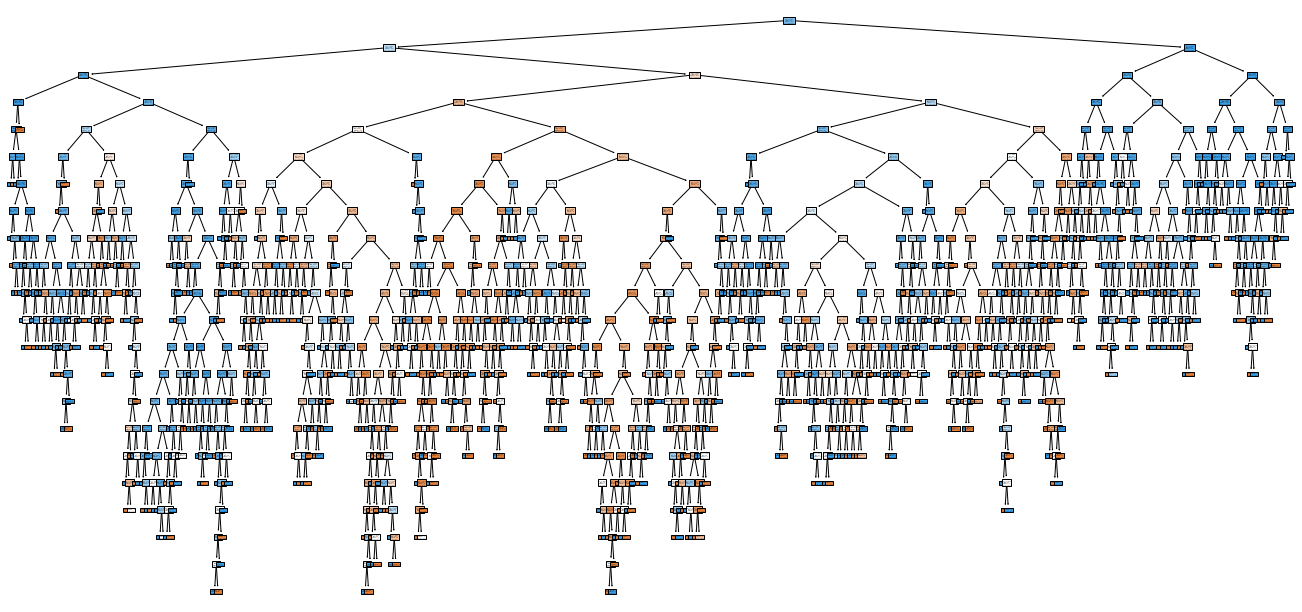

In [7]:
# 결정 트리 출력
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(23, 11))
plot_tree(dt, filled=True)
plt.show()

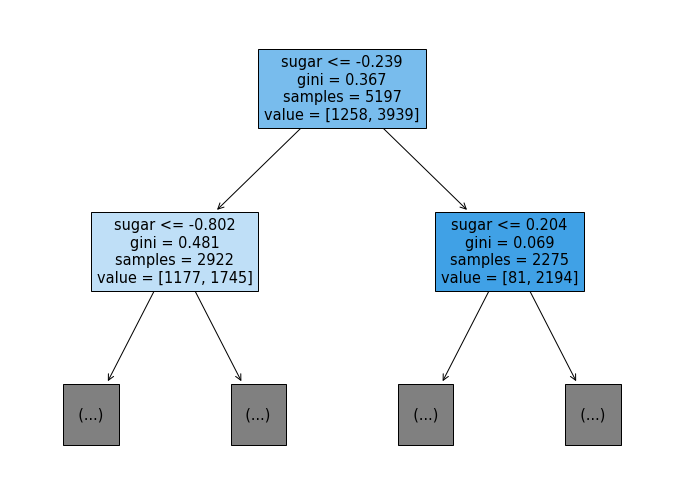

In [5]:
# 결정 트리 깊이 제한 후 출력
# max_depth: 트리 깊이, filled: 클래스에 따라 색 변경
plt.figure(figsize=(12, 9))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

위의 트리 노드를 하나씩 살펴보자. 루트 노드를 보면 당도가 -0.239 이하인지 질문한다. 조건을 만족한다면 왼쪽 노드로 이동하고, 아니라면 오른쪽 노드로 이동한다. samples에 나타난 것처럼, 루트노드에는 5197개의 샘플이 있고 왼쪽 True로 간 양성 클래스(화이트 와인) 샘플은 3939개, 오른쪽으로 간 음성 클래스(레드와인) 샘플은 1258개 있다. 이 값이 value에 나타난 값이다. 

우리는 filled=True로 지정했기 때문에, 특정 클래스의 비율이 높아질 수록 색이 더 진해진다. 더 많은 음성 클래스(레드 와인) 샘플이 오른쪽으로 이동했기 때문에 루트노드보다 자식 노드의 색이 확연히 구분이 간다

결정 트리에서 예측하는 방법은 리프 노드에서 가장 많은 클래스가 예측 클래스가 된다. 예를 들어 트리의 성장을 여기에서 멈춘다면 모든 샘플이 양성 클래스로 예측된다. 두 노드 모두 양성 클래스가 더 많기 때문이다(1177 < 1745, 81 < 2194)

### 불순도
노드 안을 보면 gini라는 것이 있는데, 이것은 **지니 불순도(Gini impurity)**를 의미한다. DecisionTreeClassifier 클래스의 criterion 매개변수의 기본값이 gini다. criterion 매개변수 용도는 노드에서 데이터 분할 기준을 정하는 것이다. 당도 -0.239를 결정할 때 지니 불순도를 사용한다. 지니 불순도 계산은 다음과 같다
$$지니\ 불순도 = 1 - (음성\ 클래스\ 비율^2 + 양성\ 클래스\ 비율^2)$$

위 계산법에 따라 루트 노드의 지니 불순도를 계산하면
$$1 - ((1258 / 5197)^2 + (3939 / 5197)^2 = 0.367$$

어떤 노드에 100개의 샘플이 있고, 이 샘플의 클래스 비율이 정확히 반이라면, 지니 불순도는 0.5로 최악이 되고, 클래스가 하나 뿐이라면 지니 불순도는 0이며 순수 노드라고 한다

결정 트리 모델은 부모 노드와 자식 노드의 불순도 차이가 가능한 크도록 트리를 성장시킨다. 불순도 차이 계산은 두 자식 노드의 불순도를 각 샘플 개수에 비례하여 모두 더하고 부모 노드의 불순도에서 뺀다. 루트노드와 그 자식 노드의 지니 불순도의 차이를 계산하면 다음과 같다.
$$부모gini - (왼쪽 샘플 / 부모 샘플) \times 왼쪽gini - (오른쪽 샘플 / 부모 샘플) \times 오른쪽gini$$
$$= 0.367 - (2922/5197) \times 0.481 - (2275/5197) \times 0.069 = 0.066$$

이렇게 계산된 불순도 차이를 **정보 이득(information gain)**이라 한다. 결정트리는 노드를 정보 이득이 최대가 되도록 데이터를 나눈다. 이때 gini 말고 다른 불순도 기준으로는 엔트로피(entrophy)가 있다. 계산은 다음과 같다(음성 클래스 비율: N, 양성 클래스 비율: P
$$-N \times log_2(N) - P \times log_2(P)$$
$$= -(1258 / 5197) \times log_2(1258 / 5197) - (3939 / 5197) \times log_2(3939 / 5197) = 0.798$$

지니 불순도와 엔트로피 불순도가 만든 결과의 차이는 크지 않으므로 계속 지니 불순도를 사용하자

### 가지치기
위의 트리는 제한 없이 자라났기 때문에 훈련셋보다 테스트셋 점수가 크게 낮았다. 제한이 없으면 결정트리는 계속 자라나는데, 이렇게 되면 훈련셋에는 잘 맞겠지만 테스트셋에는 잘 안맞는, 일반화가 잘 안될 수 있다

기본적인 가지치기로 트리의 최대 깊이를 지정할 수 있다. DecisionClassifier의 max_depth 매개변수를 3으로 지정해보자

In [8]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


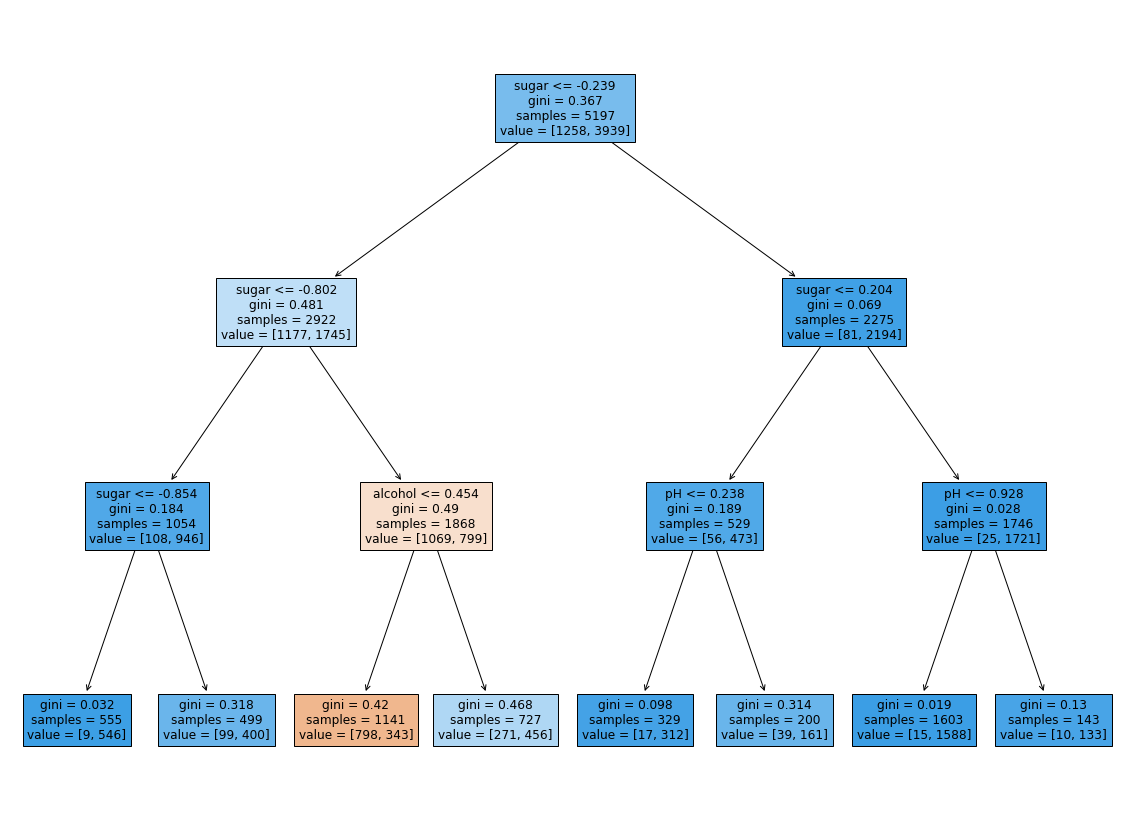

In [9]:
# 트리 그림 그려보기
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

0.8454877814123533
0.8415384615384616


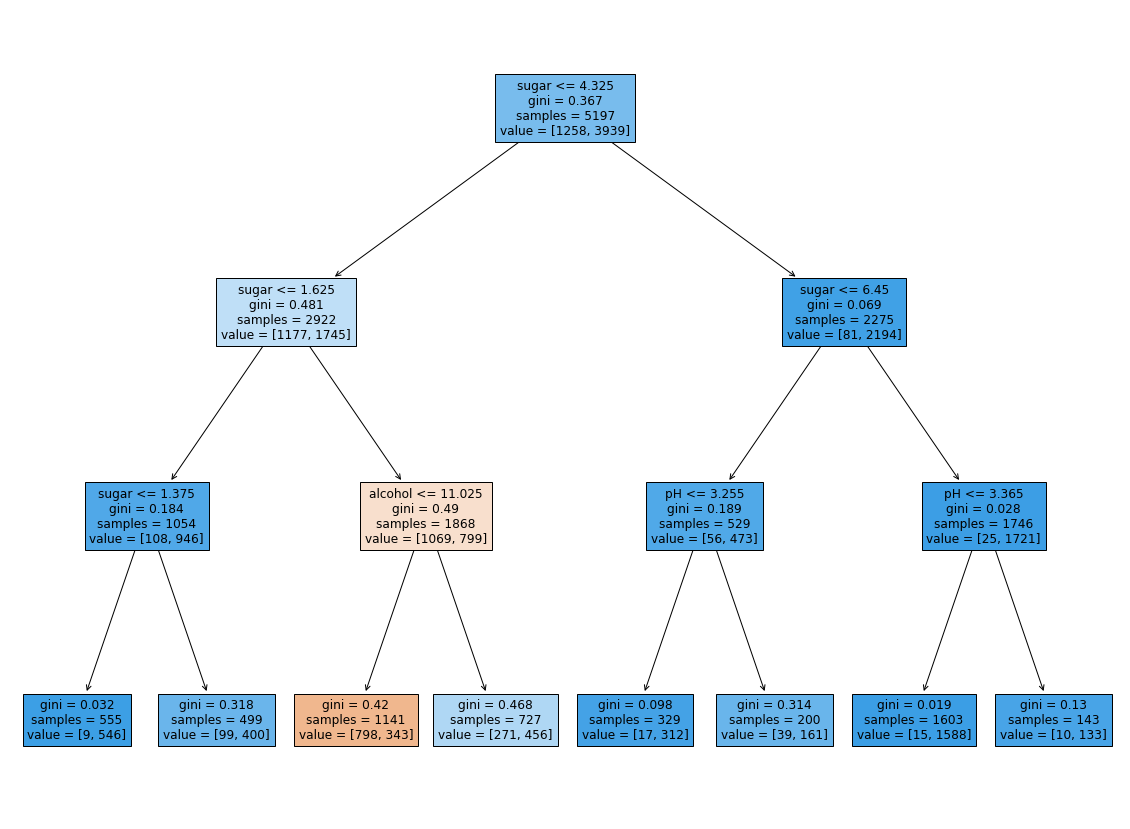

In [11]:
# 표준화 전처리하지 않은 원본 데이터 이용해 결정 트리 훈련
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

# 원본 데이터로 결정 트리 그리기
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [12]:
# 특성 중요도: 각 노드의 정보 이득과 전체 샘플에 대한 비율을 곱한 후 특성별로 더해 계산
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]
